# Imports

In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd
tqdm.pandas()

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Sample sizes (no. orders) per country in two weeks

In [2]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [3]:
query = """
SELECT
entity_id,
count(*) number_of_orders
FROM `fulfillment-dwh-production.cl.orders_v2`orders
WHERE created_date BETWEEN "2023-05-01" AND "2023-05-14"
GROUP BY entity_id
ORDER BY number_of_orders
"""

In [4]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/79 [00:00<?, ?rows/s]

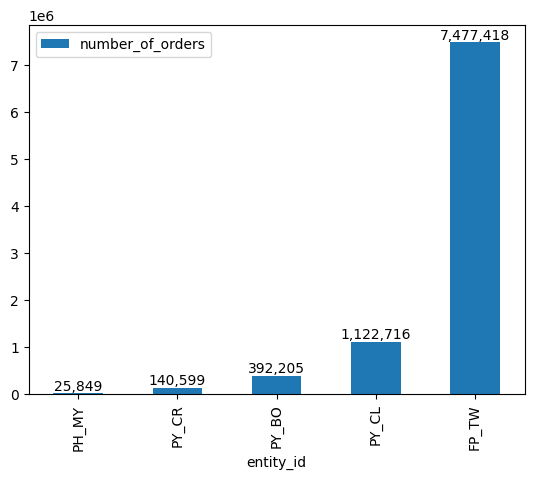

In [5]:
ax = data[data['entity_id'].isin(['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"])].set_index('entity_id').plot.bar()

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',')), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Download Data

In [6]:
def download_data(entity_ids, start_date, end_date):
    query = f"""
    SELECT
    entity_id,
    rider.city_id,
    created_date,
    created_at,
    orders.rider.timings.actual_delivery_time/60 delivery_time,
    orders.rider.timings.order_delay/60 order_delay,
    orders.rider.timings.bag_time/60 bag_time,
    --ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
    FROM `fulfillment-dwh-production.cl.orders_v2`orders
    WHERE created_date BETWEEN "{start_date}" AND "{end_date}"
    AND entity_id in {tuple(entity_ids)}
    """

    bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
    data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')
    return data

In [7]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-05-14"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/9158787 [00:00<?, ?rows/s]

In [8]:
KPI = "delivery_time"

In [9]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

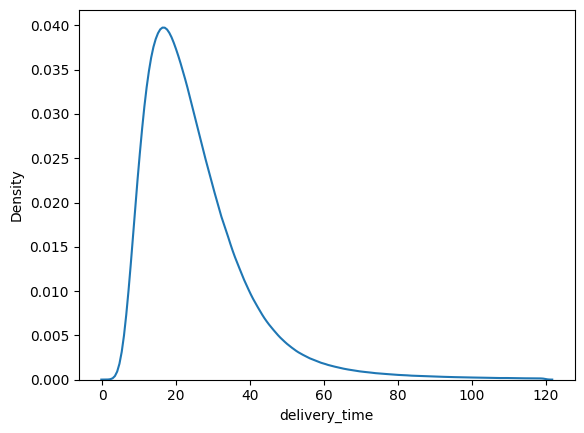

In [288]:
sns.kdeplot(data[KPI])

In [10]:
data[KPI].mean()

25.32630921140975

# Confidence Intervals per window size

In [40]:
def randomize_time_unit_assignment(data, proportion=0.5):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B'], p=[1-proportion, proportion]) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [13]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [14]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [15]:
# calculate CIs
results = data.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.37s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

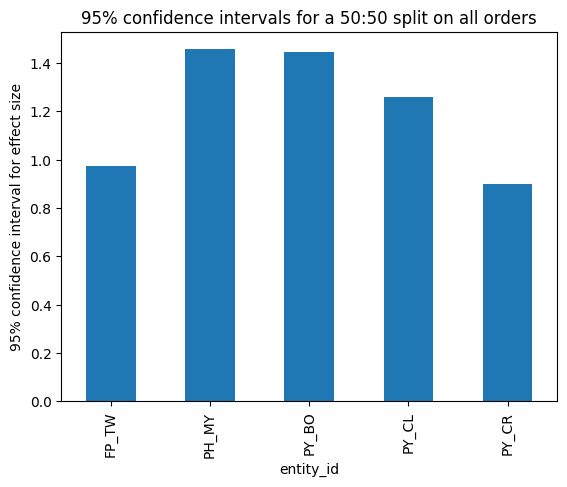

In [16]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [17]:
mean_KPI = data.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

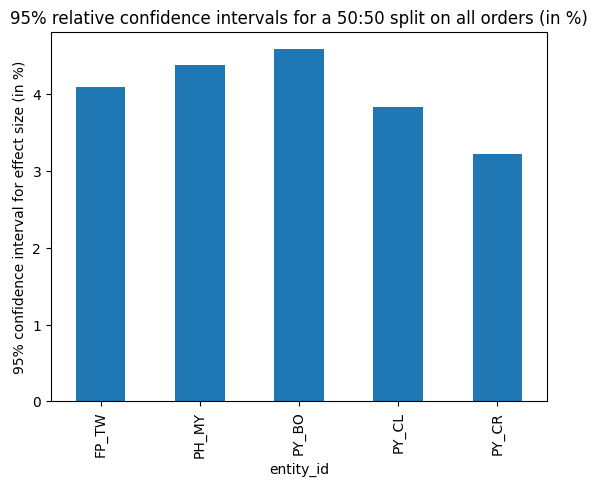

In [18]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

In [19]:
grouped_data = data.groupby(['time_unit', 'entity_id'])[KPI].mean().unstack()

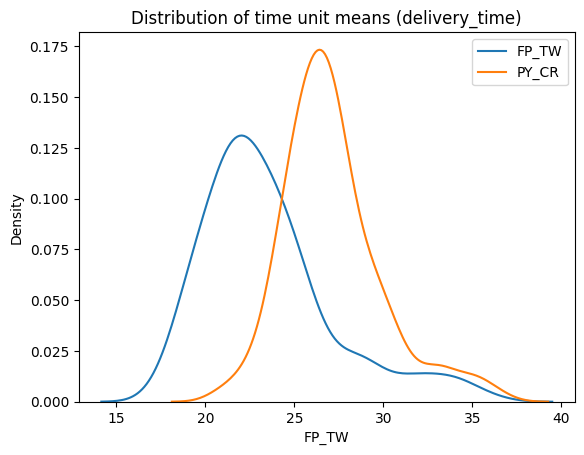

In [20]:
sns.kdeplot(grouped_data['FP_TW'])
sns.kdeplot(grouped_data['PY_CR'])
plt.title(f'Distribution of time unit means ({KPI})')
plt.legend(['FP_TW', "PY_CR"])

Text(0.5, 1.0, 'time unit means over time')

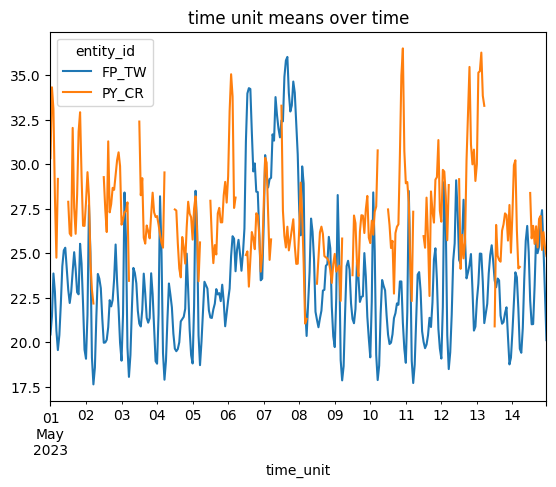

In [21]:
grouped_data[["FP_TW", "PY_CR"]].plot()
plt.title('time unit means over time')

# Increase length of test

In [274]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-06-01"
data_long_test = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/20681768 [00:00<?, ?rows/s]

In [275]:
# filter
data_long_test = data_long_test[data_long_test['delivery_time']<120]
data_long_test = data_long_test[data_long_test['delivery_time']>0]
data_long_test = data_long_test[data_long_test[KPI].notnull()]

In [276]:
# assign to group with hourly switchback interval
data_long_test['time_unit'] = data_long_test['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data_long_test)

In [277]:
# calculate CIs
results = data_long_test.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data_long_test, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.23s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

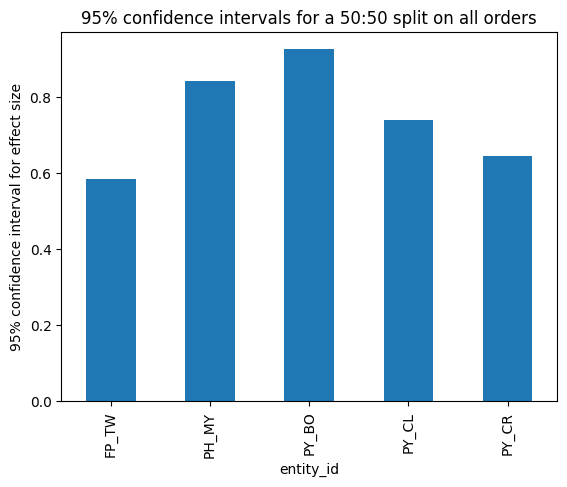

In [278]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [279]:
mean_KPI = data_long_test.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

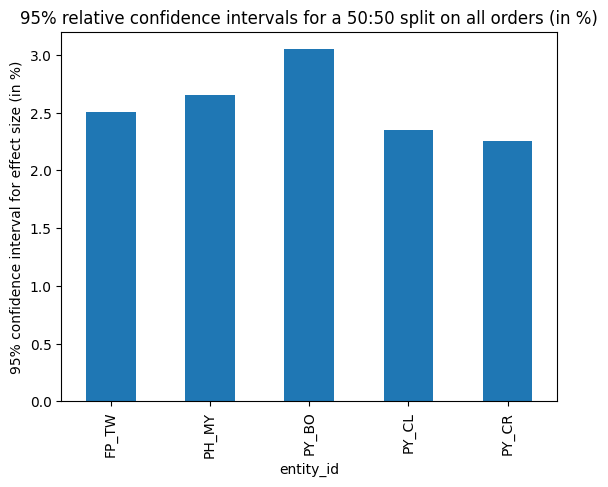

In [280]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

# City level

In [27]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

data['entity_city_id'] = data['entity_id']+data['city_id'].astype(str)

In [28]:
# calculate CIs
results = data.groupby('entity_city_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.39it/s]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

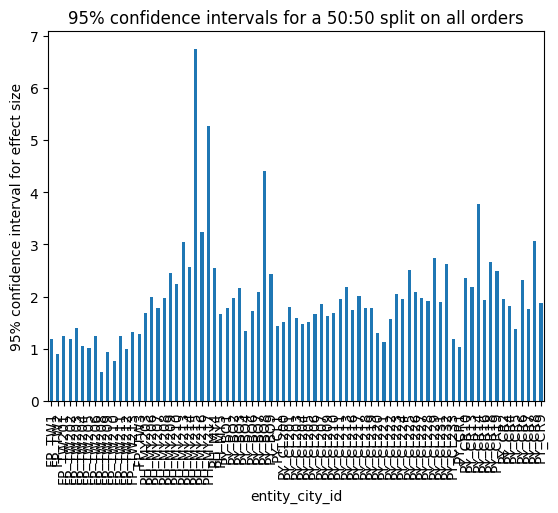

In [29]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [32]:
mean_KPI = data.groupby('entity_city_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

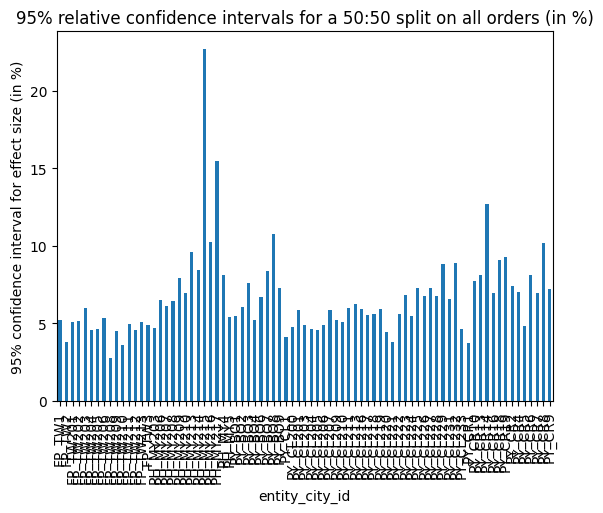

In [34]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

# Realistic datasets for surge test

## Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5

In [3]:
query = """
SELECT
*
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE
entity_id = "FP_KH" AND assignment_id = 5 AND 
created_date BETWEEN "2023-06-11" AND "2023-07-11" 
AND vendor_price_scheme_type = "Automatic scheme"
"""

In [4]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/53925 [00:00<?, ?rows/s]

### Delivery Time

<AxesSubplot:xlabel='actual_DT', ylabel='Density'>

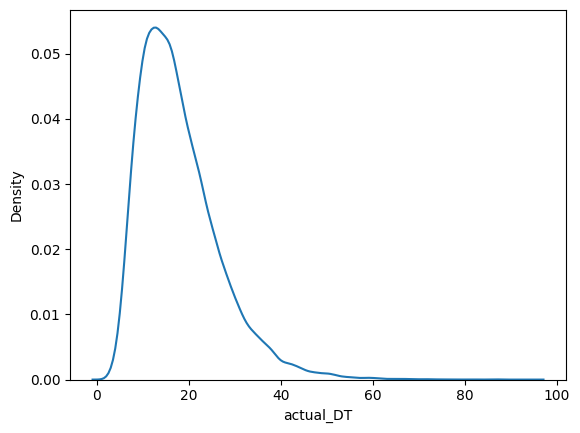

In [159]:
sns.kdeplot(data['actual_DT'])

In [203]:
data = data[data['actual_DT'].notnull()]
data = data[data['delivery_distance_m'].notnull()]

In [162]:
# assign to group with hourly switchback interval
data['time_unit'] = data['order_placed_at'].dt.floor("1H")

In [188]:
def get_results(data, KPI):
    randomize_time_unit_assignment(data, proportion=0.5)
    CI = 2*CRSE_CI(data, KPI)[0]
    
    CIs = []
    orders_affected_list = [50, 30, 20, 10, 5]
    for orders_affected in orders_affected_list:
        CIs.append(CI*100/orders_affected)
    results = pd.Series(CIs, index=[str(i)+"%" for i in orders_affected_list])
    return results

In [189]:
results = get_results(data, 'actual_DT')

Text(0.5, 0, '% of orders affected by surge')

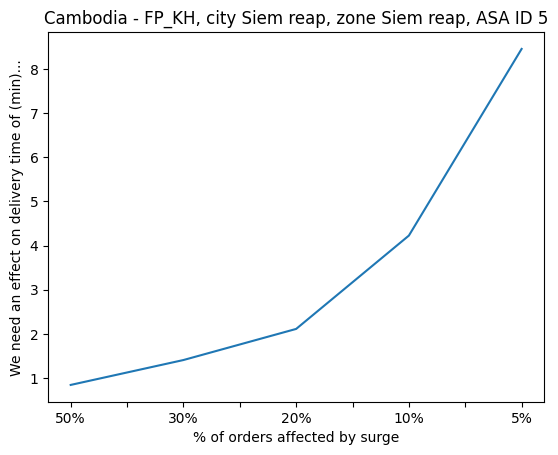

In [191]:
results.plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on delivery time of (min)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

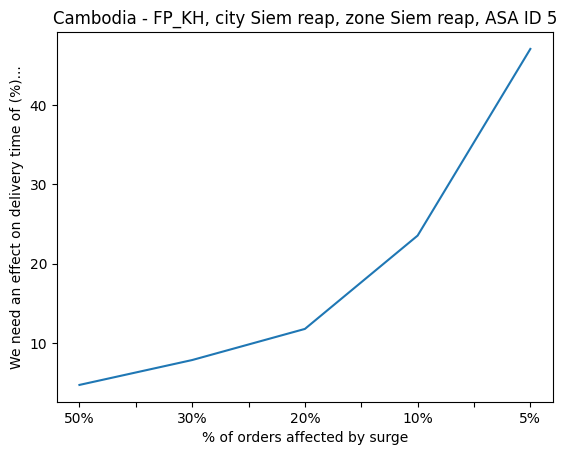

In [193]:
(100*results/data[KPI].mean()).plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on delivery time of (%)...')
plt.xlabel('% of orders affected by surge')

In [194]:
def get_CIs_for_different_window_sizes(CI_function, KPI, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CI_function(data, KPI)
        CIs.append(CI)
    return pd.Series(CIs, index=window_sizes, name=CI_function.__name__)

In [137]:
window_sizes = [str(i)+"H" for i in range(1,12)]+["1D", "2D", "3D"]
CIs = get_CIs_for_different_window_sizes(CRSE_CI, KPI, window_sizes)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.60it/s]


Text(0.5, 0, 'switchback interval')

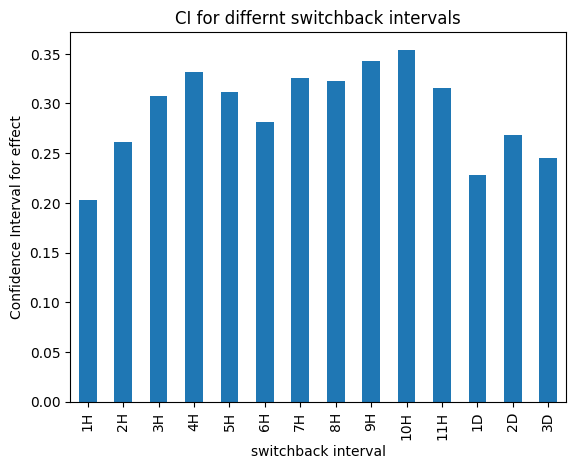

In [156]:
CIs.plot.bar()
plt.title('CI for differnt switchback intervals')
plt.ylabel('Confidence Interval for effect')
plt.xlabel('switchback interval')

Text(0.5, 1.0, 'DT mean fluctuations for different window sizes.')

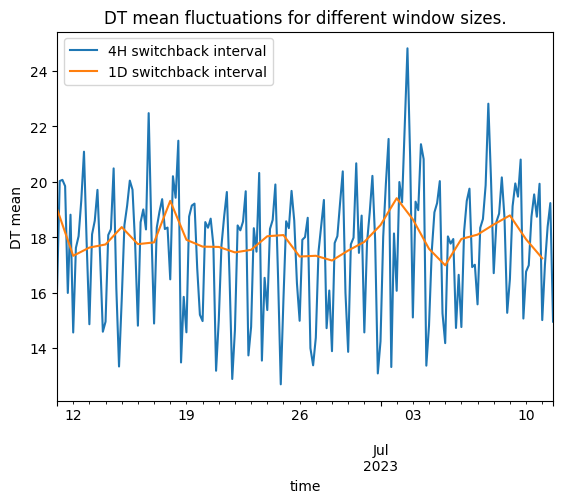

In [165]:
data['time_unit'] = data['order_placed_at'].dt.floor("4H")
data.groupby('time_unit')[KPI].mean().plot()
data['time_unit'] = data['order_placed_at'].dt.floor("1D")
data.groupby('time_unit')[KPI].mean().plot()
plt.legend(['4H switchback interval', '1D switchback interval'])
plt.xlabel('time')
plt.ylabel('DT mean')
plt.title('DT mean fluctuations for different window sizes.')

###

### Distance

<AxesSubplot:xlabel='delivery_distance_m', ylabel='Density'>

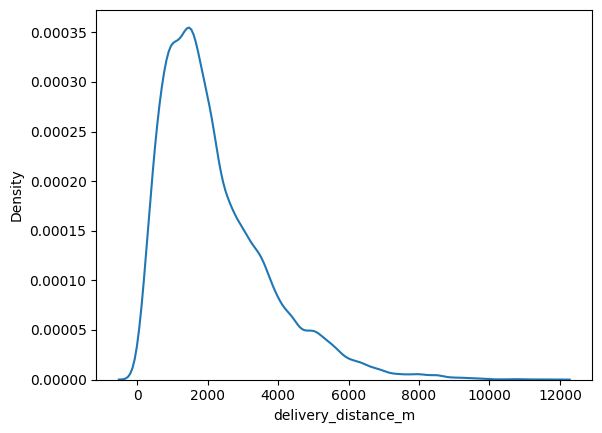

In [195]:
sns.kdeplot(data['delivery_distance_m'])

In [211]:
KPI = 'delivery_distance_m'
results = get_results(data, KPI)

Text(0.5, 0, '% of orders affected by surge')

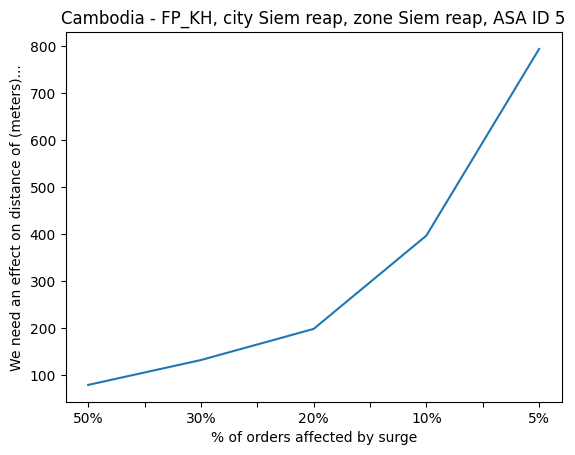

In [212]:
results.plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on distance of (meters)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

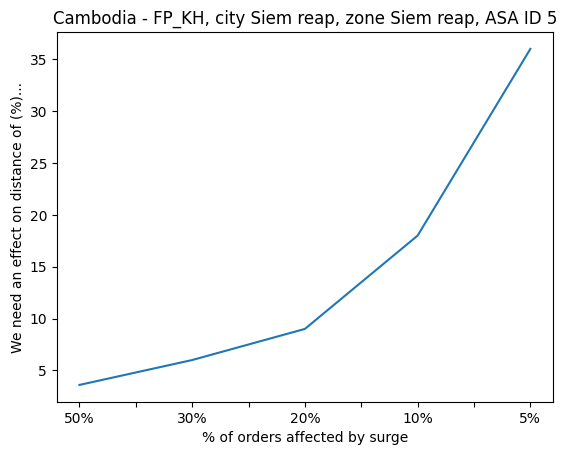

In [215]:
(100*results/data[KPI].mean()).plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on distance of (%)...')
plt.xlabel('% of orders affected by surge')

### DPS mean delay

In [225]:
data['dps_mean_delay'] = data['dps_mean_delay'].astype(float)

<AxesSubplot:xlabel='dps_mean_delay', ylabel='Density'>

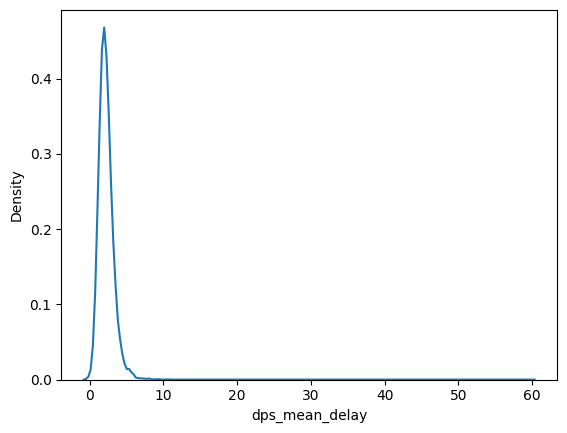

In [226]:
sns.kdeplot(data['dps_mean_delay'])

In [227]:
KPI = 'dps_mean_delay'
results = get_results(data, KPI)

Text(0.5, 0, '% of orders affected by surge')

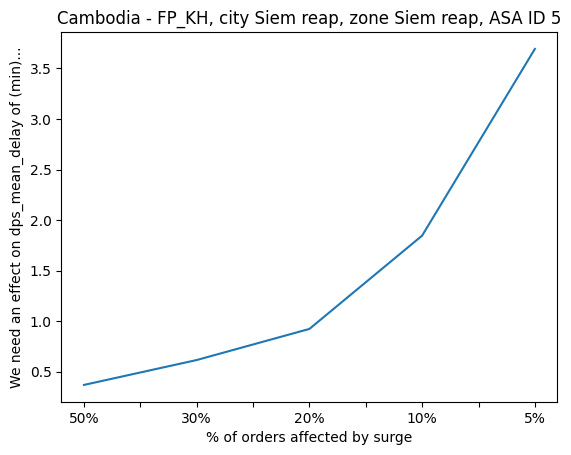

In [229]:
results.plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on dps_mean_delay of (min)...')
plt.xlabel('% of orders affected by surge')

Text(0.5, 0, '% of orders affected by surge')

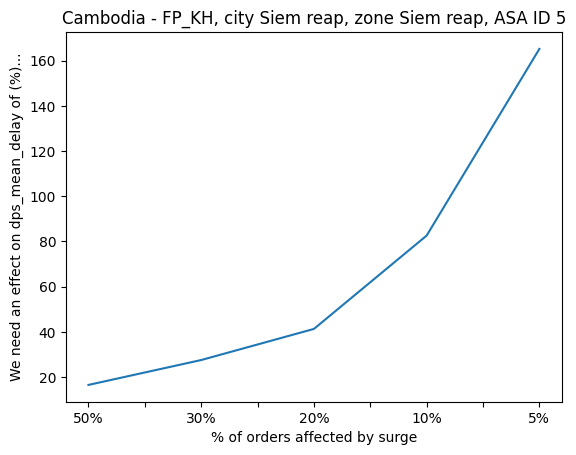

In [231]:
(100*results/data[KPI].mean()).plot()
plt.title("Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5")
plt.ylabel('We need an effect on dps_mean_delay of (%)...')
plt.xlabel('% of orders affected by surge')